In [1]:
# Downloading necessary files using gdown
!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /content/Reviews.csv
100% 301M/301M [00:03<00:00, 86.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 28.0MB/s]


In [3]:
#all imports
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [6]:
#Reading the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#checking the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
#getting only 2 columns - Text, Score
reviews = reviews.loc[:, ['Text', 'Score']]
reviews.head(5)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [8]:
#checking the NAN values
reviews.isnull().sum().sum()

0

There are zero NAN or Null values in reviews dataframe.

In [9]:
#if score<=2, set score = 0
reviews['Score'] = np.where(reviews['Score'] <= 2, 0, reviews['Score'])
#if score> 3, set score = 1
reviews['Score'] = np.where(reviews['Score'] > 3, 1, reviews['Score'])
#if score == 3, remove the rows. 
reviews.drop(reviews.loc[reviews['Score']==3].index, inplace=True)
#Checking data
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [10]:
reviews.shape

(525814, 2)

In [12]:
# Dropping reviews with word length more than 50 and sampling 0.1M reviews from dataframe
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [13]:
reviews.shape

(100000, 3)

In [14]:
#remove HTML from the Text column and save in the Text column only
#Ref:https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
def remove_html(text):
    clean_text = re.sub(r"<.*?>", '', text)
    return clean_text

reviews['Text'] = reviews.Text.apply(remove_html)

In [15]:
#print head 5
reviews.head()

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [16]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

In [17]:
#split the data into train and test data(20%) with Stratify sampling, random state 33
X = reviews['Text']
y = reviews['Score']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=33)

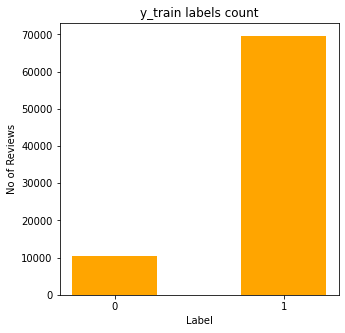

In [18]:
#plot bar graphs of y_train and y_test
%matplotlib inline
import matplotlib.pyplot as plt
u, c = np.unique(y_train, return_counts=True)
fig = plt.figure(figsize=(5,5))
plt.bar(u, c, width=0.5, color='orange')
plt.xlabel("Label")
plt.ylabel("No of Reviews")
plt.title("y_train labels count")
plt.xticks([0, 1], [0, 1])
plt.show()

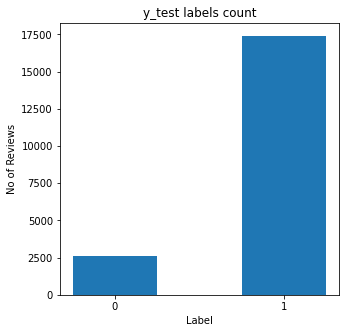

In [19]:
u, c = np.unique(y_test, return_counts=True)
fig = plt.figure(figsize=(5,5))
plt.bar(u, c, width=0.5)
plt.xlabel("Label")
plt.ylabel("No of Reviews")
plt.title("y_test labels count")
plt.xticks([0, 1], [0, 1])
plt.show()

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERT. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [22]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
# https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output, name='bert_model')


In [23]:
bert_model.summary()

Model: "bert_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',    

In [24]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [25]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [26]:
# if you are getting error for sentencepiece module you can install it using below command while running this cell for the first time
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [27]:
import tokenization #We have given tokenization.py file

In [28]:
# Create tokenizer " Instantiate FullTokenizer" 
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [65]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 
X_train_tokens = [tokenizer.tokenize(sent) for sent in X_train]
#X_train_tokens = np.asarray(X_train_tokens).reshape((80000,-1))

X_test_tokens = [tokenizer.tokenize(sent) for sent in X_test]
#X_test_tokens = np.asarray(X_test_tokens).reshape((20000,-1))

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask


def add_special_tokens_and_mask(data, max_seq_length):
    ''' This function pads/truncates the input tokens adds special tokens [CLS]
        [SEP][PAD] and also creates segment input.
        
        Input: data -> text data tokens
        Returns: 3 numpy arrays -> data_tokens, data_mask, data_segments.'''
    
    data_tokens = []
    data_mask = []
    data_segments = []
    for tokens in data:
        if len(tokens) <= max_seq_length - 2:
            lst = tokens
            lst.insert(0, '[CLS]')
            lst.append('[SEP]')
            diff = max_seq_length - len(lst)
            m1 = [1 for _ in range(len(lst))]
            m0 = [0 for _ in range(diff)]
            pad_lst = ('[PAD] ' * diff ).split()
            lst.extend(pad_lst)
            data_tokens.append(lst)
            msk = np.append(m1, m0)
            data_mask.append(msk)
        else:
            lst = tokens
            lst = tokens[0:max_seq_length-2]
            lst.insert(0, '[CLS]')
            lst.append('[SEP]')
            data_tokens.append(lst)
            data_mask.append([1 for _ in range(max_seq_length)])
        data_segments.append([0 for _ in range(max_seq_length)])
    
    data_tokens = [tokenizer.convert_tokens_to_ids(i) for i in data_tokens]
    data_tokens = np.asarray(data_tokens).reshape(-1, max_seq_length)
    data_mask = np.asarray(data_mask, dtype=np.int16).reshape(-1, max_seq_length)
    data_segments = np.asarray(data_segments).reshape(-1, max_seq_length)
    
    return data_tokens, data_mask, data_segments


# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

X_train_tokens, X_train_mask, X_train_segment = add_special_tokens_and_mask(X_train_tokens, max_seq_length=55)
X_test_tokens, X_test_mask, X_test_segment = add_special_tokens_and_mask(X_test_tokens, max_seq_length=55)

In [31]:
import pickle

In [32]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [35]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [36]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [37]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [38]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [39]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [41]:
##imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model

In [49]:
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows

input_layer=Input(shape=(X_train_pooled_output.shape[1],), name='input_layer')
dense1 = Dense(256, activation='relu', name='dense_1')(input_layer)
dense2 = Dense(128, activation='relu', name='dense_2')(dense1)
dense3 = Dense(64, activation='relu', name='dense_3')(dense2)
dense4 = Dense(16, activation='relu', name='dense_4')(dense3)
dense5 = Dense(8, activation='relu', name='dense_5')(dense4)
output_layer = Dense(1, activation='sigmoid', name='output_layer')(dense5)

model = Model(inputs=input_layer, outputs=output_layer, name='model_1')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 768)]             0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 output_layer (Dense)        (None, 1)                 9   

In [43]:
# Defining auc metric
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, [y_true, y_pred], tf.double, name='roc_auc')

In [44]:
import os
from datetime import datetime

In [45]:
if 'model' not in os.listdir():
   os.mkdir('model')
   os.mkdir('model/saved_models/')
   os.mkdir('model/tb_logs')

save_path = 'model/saved_models/epoch_{epoch:02d}_val_auc_{val_auc:.4f}.hdf5' 
logs_path = 'model/tb_logs/'+ datetime.now().strftime("%HH%MM%SS")

In [50]:
# Imprting necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

saver = ModelCheckpoint(save_path, monitor='val_auc')
stopper = EarlyStopping(monitor='val_loss', patience=5, mode='min')
tb = TensorBoard(logs_path)
callbacks = [saver, stopper, tb]

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics = ['accuracy', auc])

hist = model.fit(X_train_pooled_output, y_train, epochs=50, batch_size=128,
                 validation_data=[X_test_pooled_output, y_test],
                 callbacks = callbacks)

Epoch 1/50
625/625 [==============================] - 4s 5ms/step - loss: 0.2587 - accuracy: 0.8937 - auc: 0.9014 - val_loss: 0.2015 - val_accuracy: 0.9169 - val_auc: 0.9374
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 0.2060 - accuracy: 0.9145 - auc: 0.9452 - val_loss: 0.1964 - val_accuracy: 0.9215 - val_auc: 0.9417
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.1935 - accuracy: 0.9197 - auc: 0.9498 - val_loss: 0.1822 - val_accuracy: 0.9272 - val_auc: 0.9472
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.1870 - accuracy: 0.9238 - auc: 0.9525 - val_loss: 0.1803 - val_accuracy: 0.9275 - val_auc: 0.9488
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.1868 - accuracy: 0.9235 - auc: 0.9541 - val_loss: 0.1781 - val_accuracy: 0.9286 - val_auc: 0.9497
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.1851 - accuracy: 0.9249 - auc: 0.9555 - val_loss: 0.19

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/model/tb_logs/13H12M08S

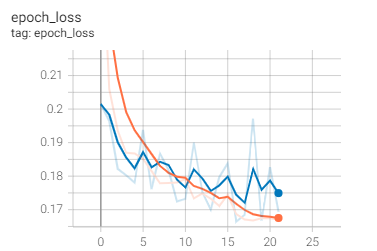
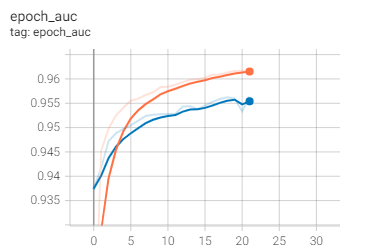

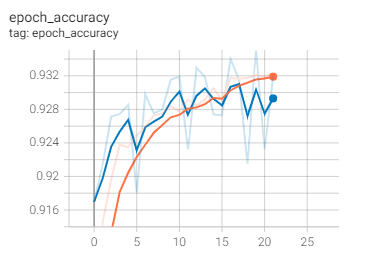

By analyzing above plots and training logs, model state at 17th epoch is chosen as best model.

In [55]:
from tensorflow.keras.models import load_model
best_model = load_model('/content/model/saved_models/epoch_17_val_auc_0.9553.hdf5',
                        custom_objects={'auc': auc})

In [57]:
eval = best_model.evaluate(X_test_pooled_output, y_test, batch_size=128)

157/157 [==============================] - 1s 5ms/step - loss: 0.1664 - accuracy: 0.9340 - auc: 0.9553


In [59]:
print("Best Model Parameters: ")
print(f"Val_loss : {np.round(eval[0], 4)}")
print(f"Val_accuracy : {np.round(eval[1], 4)}")
print(f"Val_auc : {np.round(eval[2], 4)}")

Best Model Parameters: 
Val_loss : 0.1664
Val_accuracy : 0.934
Val_auc : 0.9553


<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [60]:
!gdown --id 1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo
To: /content/test.csv
100% 62.1k/62.1k [00:00<00:00, 78.5MB/s]


In [61]:
#read the csv file
test_df= pd.read_csv('test.csv')

In [70]:
# Creating Pipeline
def predict_review_sentiment(data, model, max_seq_length=55):

    # Removing html tags
    text_data = data.Text.apply(remove_html)

    # Tokenizing
    tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case)
    text_tokens = [tokenizer.tokenize(sent) for sent in text_data]

    # Pad, mask, segment tokens
    text_tokens, text_mask, text_segment = add_special_tokens_and_mask(text_tokens, max_seq_length=max_seq_length)

    # Getting bert encodings
    X_test = bert_model.predict([text_tokens, text_mask, text_segment])
    print(f"X_test shape: {X_test.shape}")

    # Predicting review sentiment
    preds = model.predict(X_test)
    def get_label(ar):
        for i, l in enumerate(ar):
            if l >= 0.5:
                ar[i] = 1
            else:
                ar[i] = 0
        return ar
    
    preds = get_label(preds)
    
    return preds

In [71]:
predictions = predict_review_sentiment(test_df, model=best_model)

X_test shape: (352, 768)


In [73]:
print(predictions[0:5])

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [78]:
# Verifying predictions for first 5 test reviews
from prettytable import PrettyTable
table = PrettyTable(field_names=['Review Text', 'Model Prediction'], align='l')
table.add_rows([[text, pred] for text, pred in zip(test_df['Text'].values[0:5], predictions[0:5])])

print(table)
print("Model Prediction [0.] : Negative Review ")
print("Model Prediction [1.] : Positive Review ")

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
| Review Text                                                                                                                                                                                                                                                    | Model Prediction |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
| Just opened Greenies Joint Care (individually sealed) in December 2011 and found small worm crawling all over it.  Next one looked fine, but really supposed to trus

From above examples we can say that our model is giving correct sentiments about the reviews. 

**Assignment Objective :** To use Transfer Learning based on BERT Encodings to classify the given review as positive or negative.

**Steps Followed :**

1. Getting the reviews text data and their labels.
2. Cleaning (preprocessing) the review text by removing html tokens present (if any) in the review text.
3. Tokenizing the review text by using Tokenizer class in the tokenization.py file.
4. Adding BERT special tokens like [CLS], [SEP], [PAD] to the text tokens and converting them into token IDs. Also creating mask_input and segment_input arrays for each sequence of tokens.
5. Creating pretrained bert model using tf.hub and keras layer.
6. Giving 3 inputs, token_ids, mask_input and segment_input to bert model and getting predicted 768 dimensional BERT encodings corresponding to the [CLS] token for each input.
7. A simple feed forward neural network with dense layers and sigmoid activation output with input as BERT 768 dimensional encodings and corresponding labels is trained.
8. This dense model is used to predict the review sentiment as positive [1] or  negative [0].